#**Task 1**


Importing Libraries:

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

Defining the Environment

In [2]:
env=gym.make('Blackjack-v1', sab=True, render_mode="rgb_array")
done=False
observation=env.reset()
action=env.action_space.sample()
observation, reward, terminated, truncated,info=env.step(action)
n_states=env.observation_space[0].n*env.observation_space[1].n*env.observation_space[2].n
n_actions=env.action_space.n

Q-Table Initialization:

In [3]:
def _init_q_table():
  return np.zeros(n_states,n_actions)

Q-Table Update:

In [4]:
def Q_update(
    Q:np.ndarray,
    s:tuple[int,int,bool],
    a:int,
    r:float,
    s_next:tuple[int,int,bool],
    alpha:float,
    gamma:float,
):
  return Q[s,a]+alpha*(r+gamma*np.max(Q[s_next])-Q[s,a])


# **Task 2**

Importing libraries

In [5]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import pygame
import gymnasium as gym
from gymnasium import spaces
from tqdm import tqdm
from collections import defaultdict

Defining actions

In [6]:
class Actions(Enum):
    RIGHT = 0
    UP = 1
    LEFT = 2
    DOWN = 3

Defining the environment

In [7]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    def __init__(self, render_mode=None, size=4):
      self.size = size
      self.window_size = 512
      self.observation_space = spaces.Dict(
          {
              "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
              "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
          }
      )
      self._agent_location = np.array([-1, -1], dtype=int)
      self._target_location = np.array([-1, -1], dtype=int)
      self.action_space = spaces.Discrete(4)
      self._action_to_direction = {
          Actions.RIGHT.value: np.array([1, 0]),
          Actions.UP.value: np.array([0, 1]),
          Actions.LEFT.value: np.array([-1, 0]),
          Actions.DOWN.value: np.array([0, -1]),
      }

      assert render_mode is None or render_mode in self.metadata["render_modes"]
      self.render_mode = render_mode
      self.window = None
      self.clock = None

    def _get_obs(self):
      return {"agent": self._agent_location, "target": self._target_location}


    def _get_info(self):
      return {
        "distance": np.linalg.norm(
        self._agent_location - self._target_location, ord=1
      )
    }

    def reset(self, seed=None, options=None):
      super().reset(seed=seed)
      self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
      self._target_location = self._agent_location
      while np.array_equal(self._target_location, self._agent_location):
        self._target_location = self.np_random.integers(
          0, self.size, size=2, dtype=int
        )
      observation = self._get_obs()
      info = self._get_info()
      if self.render_mode == "human":
        self._render_frame()
      return observation, info

    def step(self, action):
      direction = self._action_to_direction[action]
      self._agent_location = np.clip(
        self._agent_location + direction, 0, self.size - 1
      )
      terminated = np.array_equal(self._agent_location, self._target_location)
      reward = 1 if terminated else 0
      observation = self._get_obs()
      info = self._get_info()

      if self.render_mode == "human":
        self._render_frame()
      return observation, reward, terminated, False, info

    def render(self):
      if self.render_mode == "rgb_array":
        return self._render_frame()

    def _render_frame(self):
      if self.window is None and self.render_mode == "human":
        pygame.init()
        pygame.display.init()
        self.window = pygame.display.set_mode(
          (self.window_size, self.window_size)
        )
      if self.clock is None and self.render_mode == "human":
        self.clock = pygame.time.Clock()

      canvas = pygame.Surface((self.window_size, self.window_size))
      canvas.fill((255, 255, 255))
      pix_square_size = (
        self.window_size / self.size
      )

      pygame.draw.rect(
        canvas,
        (255, 0, 0),
        pygame.Rect(
            pix_square_size * self._target_location,
            (pix_square_size, pix_square_size),
        ),
      )

      pygame.draw.circle(
        canvas,
        (0, 0, 255),
        (self._agent_location + 0.5) * pix_square_size,
        pix_square_size / 3,
      )

      for x in range(self.size + 1):
        pygame.draw.line(
            canvas,
            0,
            (0, pix_square_size * x),
            (self.window_size, pix_square_size * x),
            width=3,
        )
        pygame.draw.line(
            canvas,
            0,
            (pix_square_size * x, 0),
            (pix_square_size * x, self.window_size),
            width=3,
        )

      if self.render_mode == "human":
        self.window.blit(canvas, canvas.get_rect())
        pygame.event.pump()
        pygame.display.update()
        self.clock.tick(self.metadata["render_fps"])
      else:
        return np.transpose(
            np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
        )

    def close(self):
      if self.window is not None:
        pygame.display.quit()
        pygame.quit()


Initializing the environmant

In [8]:
env = GridWorldEnv(render_mode=None)

Creating the agent

In [9]:
from typing import Tuple
Q = defaultdict(lambda: np.zeros(env.action_space.n))
class GridWorldAgent:
    def __init__(
            self,
            learning_rate:float,
            initial_epsilon:float,
            epsilon_decay:float,
            final_epsilon:float,
            discount_factor:float =0.5
    ):

      self.lr=learning_rate
      self.discount_factor=discount_factor
      self.epsilon=initial_epsilon
      self.epsilon_decay=epsilon_decay
      self.final_epsilon= final_epsilon

      self.training_error=[]

    def select_action(self, Q, state: dict, epsilon) -> int:
      state_tuple = (tuple(state['agent']), tuple(state['target']))
      if np.random.random() < epsilon:
        return env.action_space.sample()
      else:
        return int(np.argmax(Q[state_tuple]))

    def update(
      self,
      state: dict,
      action: int,
      reward: float,
      terminated: bool,
      next_state: dict
    ):
      state_tuple = (tuple(state['agent']), tuple(state['target']))
      next_state_tuple = (tuple(next_state['agent']), tuple(next_state['target']))

      future_Q = (not terminated) * np.max(Q[next_state_tuple])
      temporal_difference = (
          reward + self.discount_factor * future_Q - Q[state_tuple][action]
      )

      Q[state_tuple][action] = (
          Q[state_tuple][action] + self.lr * temporal_difference
      )
      self.training_error.append(temporal_difference)


    def decay_epsilon(self):
      epsilon=max(self.final_epsilon,self.epsilon-self.epsilon_decay)


Training

In [10]:
learning_rate=0.1
n_episodes=500
start_epsilon=1.0
epsilon_decay=start_epsilon/(n_episodes/2)
final_epsilon=0.1
agent=GridWorldAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
    )

from IPython.display import clear_output
import matplotlib.pyplot as plt

episode_rewards=[]
for episode in tqdm(range(n_episodes)):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(Q, state, agent.epsilon)
        next_state, reward, terminated, _, info = env.step(action)
        agent.update(state, action, reward, terminated, next_state)
        total_reward += reward
        done = terminated
        state = next_state

    agent.decay_epsilon()
    episode_rewards.append(total_reward)


env.render_mode = "rgb_array"  # Get frames as arrays
state, _ = env.reset()
done = False
frames = []

while not done:
    action = agent.select_action(Q, state, 0)
    next_state, _, done, _, _ = env.step(action)
    frame = env.render()
    frames.append(frame)
    state = next_state
agent.decay_epsilon()


100%|██████████| 500/500 [00:00<00:00, 779.23it/s]


Moving Average Reward

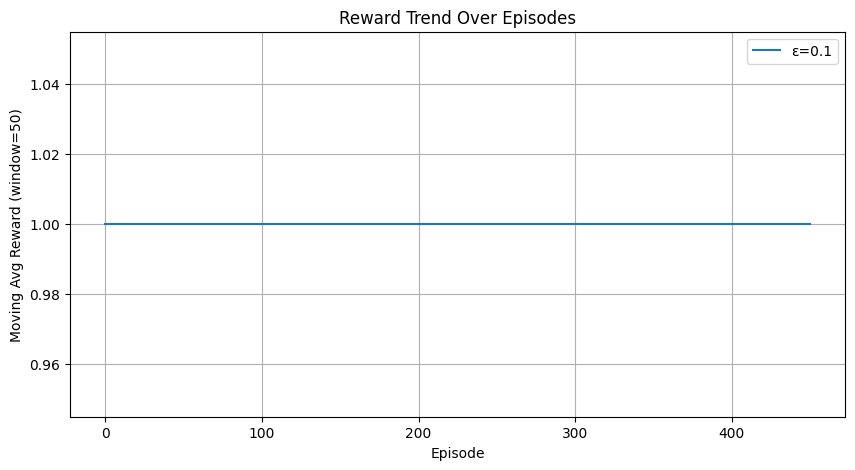

In [11]:
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(moving_average(episode_rewards), label=f'ε={final_epsilon}')
plt.xlabel('Episode')
plt.ylabel('Moving Avg Reward (window=50)')
plt.title('Reward Trend Over Episodes')
plt.legend()
plt.grid(True)
plt.show()

Graphs for epsilon = 0.1 and 0.2

In [12]:
def train_and_get_rewards(final_epsilon):
    agent = GridWorldAgent(
        learning_rate=0.1,
        initial_epsilon=1.0,
        epsilon_decay=1.0 / (n_episodes / 2),
        final_epsilon=final_epsilon
    )

    episode_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(Q, state, agent.epsilon)
            next_state, reward, terminated, _, _ = env.step(action)
            agent.update(state, action, reward, terminated, next_state)
            total_reward += reward
            state = next_state
            done = terminated

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

    return episode_rewards


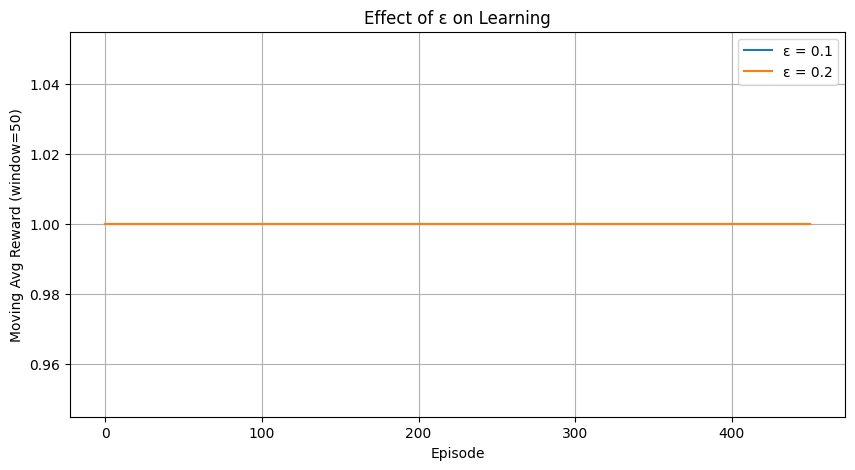

In [13]:
rewards_eps_01 = train_and_get_rewards(0.1)
rewards_eps_02 = train_and_get_rewards(0.2)

plt.figure(figsize=(10, 5))
plt.plot(moving_average(rewards_eps_01), label='ε = 0.1')
plt.plot(moving_average(rewards_eps_02), label='ε = 0.2')
plt.xlabel('Episode')
plt.ylabel('Moving Avg Reward (window=50)')
plt.title('Effect of ε on Learning')
plt.legend()
plt.grid(True)
plt.show()


**Explanation**:


# **Task 3**

Importing Libraries

In [14]:
import random
import numpy as np

Replay Buffer Implementation:

In [15]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
          raise ValueError(f"Buffer has only {len(self.buffer)} elements, but requested batch size is {batch_size}")
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


Demonstration

In [16]:
buffer = ReplayBuffer(capacity=100)

for _ in range(100):
    state = np.random.randint(0, 10, size=(4,))
    action = np.random.randint(0, 5)
    reward = np.random.random()
    next_state = np.random.randint(0, 10, size=(4,))
    done = np.random.choice([True, False])
    buffer.push(state, action, reward, next_state, done)

states, actions, rewards, next_states, dones = buffer.sample(32)

print("States:", states.shape, states.dtype)
print("Actions:", actions.shape, actions.dtype)
print("Rewards:", rewards.shape, rewards.dtype)
print("Next States:", next_states.shape, next_states.dtype)
print("Dones:", dones.shape, dones.dtype)


States: (32, 4) int32
Actions: (32,) int64
Rewards: (32,) float64
Next States: (32, 4) int32
Dones: (32,) bool


# **Task 4**

Importing libraries

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

DQN Network Architecture

In [19]:
class DQN_Policy(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DQN_Policy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)

class DQN_Target(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DQN_Target, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)


Target Network Update

In [20]:
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# **Task 5**

Importing Libraries

In [23]:
!pip install numpy==1.23.5

In [26]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

Hyperparameters

In [27]:
N = 500
M = (1.0 - 0.01) / N
X = 10
BATCH_SIZE = 64
GAMMA = 0.99
REPLAY_CAPACITY = 10000
LEARNING_RATE = 0.001

Replay Buffer Implementation

In [28]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)


DQN Network Architecture

In [29]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

Target Network Update

In [30]:
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

Initialize environment, networks, optimizer, loss, replay buffer

In [36]:
env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_net = DQN(obs_dim, n_actions)
target_net = DQN(obs_dim, n_actions)
update_target(policy_net, target_net)

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer(REPLAY_CAPACITY)

ImportError: cannot import name 'NP_SUPPORTED_MODULES' from 'torch._dynamo.utils' (c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\torch\_dynamo\utils.py)

Epsilon-Greedy

In [32]:
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        return q_values.argmax().item()

Training Loop

In [33]:
episode_rewards = []

for episode in range(1, N+1):
    state = env.reset()
    done = False
    total_reward = 0

    epsilon = max(0.01, 1.0 - M * episode)

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state

        if len(replay_buffer) >= BATCH_SIZE:
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)
            q_values = policy_net(states)
            state_action_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                next_q_values = target_net(next_states)
                next_state_values = next_q_values.max(1)[0]
                next_state_values[dones == 1] = 0.0
            expected_q_values = rewards + GAMMA * next_state_values
            loss = loss_fn(state_action_values, expected_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    episode_rewards.append(total_reward)
    if episode % X == 0:
        update_target(policy_net, target_net)
    if episode % (N // 10) == 0:
        moving_avg = np.mean(episode_rewards[-(N // 10):])
        print(f"Episode {episode}, Moving Average Reward: {moving_avg:.2f}, Epsilon: {epsilon:.3f}")

ValueError: too many values to unpack (expected 4)

Moving average reward and final success rate

c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide


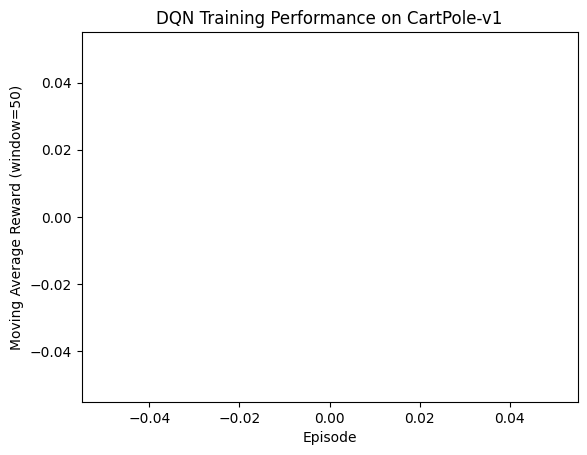

Final Success Rate: 0.00%


In [34]:
window = N // 10
moving_avgs = [np.mean(episode_rewards[i:i+window]) for i in range(0, N-window+1, window)]
plt.plot(range(0, N-window+1, window), moving_avgs)
plt.xlabel("Episode")
plt.ylabel(f"Moving Average Reward (window={window})")
plt.title("DQN Training Performance on CartPole-v1")
plt.show()

success_episodes = sum(r >= 195 for r in episode_rewards)
success_rate = (success_episodes / N) * 100
print(f"Final Success Rate: {success_rate:.2f}%")